In [87]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

## AR Model

In [20]:
datafile = "../data/daily/stocks/nyse/ABBV.csv"
df = pd.read_csv(datafile)
df.index = pd.to_datetime(df.date)
df.head()

,date,open,high,low,close,adj close,volume
date,,,,,,,
2017-07-31,2017-07-31,70.519997,70.580002,69.830002,69.910004,55.601021,7770400
2017-08-01,2017-08-01,70.029999,70.839996,69.849998,70.379997,55.974831,6681700
2017-08-02,2017-08-02,70.250000,70.739998,69.930000,70.709999,56.237282,4922200
2017-08-03,2017-08-03,70.610001,71.010002,70.360001,70.989998,56.459969,4400400
2017-08-04,2017-08-04,71.169998,71.370003,70.349998,70.989998,56.459969,4732500


In [21]:
p = df["adj close"]
r = p.pct_change()
r = r.dropna()
lr = np.log(r+1)
lr.head()

date
2017-08-01    0.006701
2017-08-02    0.004678
2017-08-03    0.003952
2017-08-04    0.000000
2017-08-07    0.003235
Name: adj close, dtype: float64

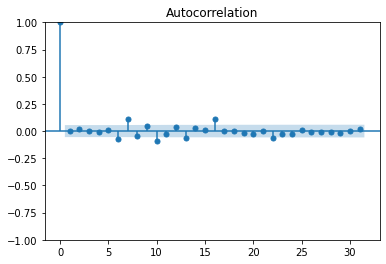

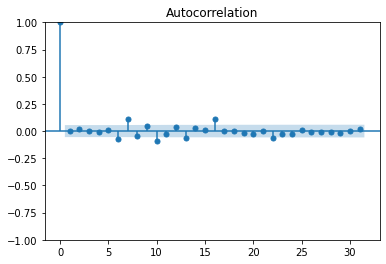

In [22]:
plot_acf(lr)

We observe significant autocorrelation at lag=7 and 10, we will try an AR(10) model

In [27]:
mod = ARIMA(lr,order=(10,0,0))
res = mod.fit() 
print(res.summary())

/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              adj close   No. Observations:                 1258
Model:                ARIMA(10, 0, 0)   Log Likelihood                3274.363
Date:                Tue, 16 Aug 2022   AIC                          -6524.726
Time:                        16:58:46   BIC                          -6463.078
Sample:                             0   HQIC                         -6501.558
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.397      0.162      -0.000       0.002
ar.L1          0.0223      0.021      1.056      0.291      -0.019       0.064
ar.L2          0.0048      0.021      0.232      0.8

We observe significance at the 5% level for lag = 6,7,8,10. We create a new definitive model with just those lags

For a more refined process, use the PACF or AIC criterions to decide what lag order to choose.

In [29]:
mod2 = ARIMA(lr,order=([6,7,8,10],0,0))
res2 = mod2.fit() 
print(res2.summary())

/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                    
Dep. Variable:                      adj close   No. Observations:                 1258
Model:             ARIMA([6, 7, 8, 10], 0, 0)   Log Likelihood                3272.173
Date:                        Tue, 16 Aug 2022   AIC                          -6532.346
Time:                                17:00:33   BIC                          -6501.522
Sample:                                     0   HQIC                         -6520.762
                                       - 1258                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.535      0.125      -0.000       0.002
ar.L6         -0.0726      0.021     -3.380      0.001      -0.115 

If the model is adequate, the residual series should behave as a white noise series. To check the resemblence of the residuals to white noise, the ACF of the residuals or the Ljung-Box statistics can be used. 

The Ljung-Box statistic does not reject the hypothesis that the residual series is white noise at any significance level, so the model is adequate. 

We will now create a 1-step look ahead forecast

In [99]:
lrdf = pd.DataFrame(lr)
lrdf = lrdf.reset_index()
lrdf.columns=["date","lr"]
coef = res2.params[:-1].to_dict()
lrdf["forecast"] = lrdf["lr"].shift(6)*coef["ar.L6"] + lrdf["lr"].shift(7)*coef["ar.L7"] + lrdf["lr"].shift(8)*coef["ar.L8"] + lrdf["lr"].shift(10)*coef["ar.L10"] + coef["const"]
lrdf["naive forecast"] = lrdf["lr"].shift(1)
lrdf = lrdf.dropna()
print("Forecast R2: ",r2_score(lrdf.lr,lrdf.forecast)*100,"%")
print("Naive Forecast R2: ",r2_score(lrdf.lr,lrdf["naive forecast"])*100,"%")

Forecast R2:  2.8794754006885026 %
Naive Forecast R2:  -98.67159048320518 %


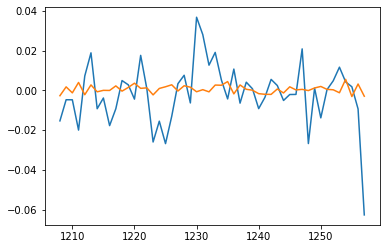

In [100]:
plt.plot(lrdf.lr[-50:])
plt.plot(lrdf.forecast[-50:])

## ARMA Model

In [102]:
mod = ARIMA(lr,order=(0,0,10))
res = mod.fit()
print(res.summary())

/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fcelaya/quant/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              adj close   No. Observations:                 1258
Model:                ARIMA(0, 0, 10)   Log Likelihood                3270.807
Date:                Tue, 16 Aug 2022   AIC                          -6517.614
Time:                        18:15:08   BIC                          -6455.966
Sample:                             0   HQIC                         -6494.446
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.381      0.167      -0.000       0.002
ma.L1          0.0132      0.021      0.635      0.526      -0.028       0.054
ma.L2          0.0164      0.020      0.806      0.4